# Part 4 - Hypothesis Testing

For part 4 of the project, I will be using my MySQL database from part 3 to answer meaningful questions for your stakeholder.

They want me to use your hypothesis testing and statistics knowledge to answer 3 questions about what makes a successful movie.

## Questions to Answer
- Q1: Does the MPAA rating of a movie (G/PG/PG-13/R) affect how much revenue the movie generates? If so, which rating earns the most revenue?
    - Q1B: What if compare ROI instead of revenue?
- Q2; Do movies that are over 2.5 hours long earn more revenue than movies that are 1.5 hours long (or less)?

- Q3: Do movies released in 2020 earn less revenue than movies released in 2018?

- Q4: Do some movie genres earn more revenue than others?
- Q5: Are some genres more highly rated than others?

## Hypothesis Testing Workflow

In [63]:
from IPython.display import Markdown
with open("Reference/hypothesis_testing_workflow.md") as f:
    how_to = f.read()
# Markdown(how_to)

# Imports and Loading

In [7]:
# Importing custom function for project
%load_ext autoreload
%autoreload 2
import project_functions as pf

In [8]:
!pip install -U dojo_ds -q
import dojo_ds as ds
ds.__version__

'1.0.9'

In [9]:
import json
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt

fav_style = ('ggplot','fivethirtyeight')#,'tableau-colorblind10')
fav_context  ={'context':'notebook', 'font_scale':1.1}
plt.style.use(fav_style)
sns.set_context(**fav_context)
plt.rcParams['savefig.transparent'] = False
plt.rcParams['savefig.bbox'] = 'tight'

In [17]:
import sqlalchemy 
sqlalchemy.__version__

'1.4.49'

In [18]:
# !pip install pymysql
import pymysql
pymysql.install_as_MySQLdb()
from sqlalchemy import create_engine
from sqlalchemy import text
from sqlalchemy_utils import create_database, database_exists
from urllib.parse import quote_plus

## Getting mysql server password
import json
with open('/Users/codingdojo/.secret/mysql.json') as f:
    login = json.load(f)

login.keys()

dict_keys(['user', 'password', 'port', 'host', 'database'])

In [6]:
# from custom_functions import aws_mysql
# conn = aws_mysql.connect_to_aws_rds(creds_file="/Users/codingdojo/.secret/aws-personal.json")
# conn
connect_str = f"mysql+pymysql://{login['user']}:{quote_plus(login['password'])}@{login['host']}/{login['database']}"

## Check if database exists
if database_exists(connect_str) == False:
    raise Exception("Database doesn't exist!")
    # create_database(connect_str)
else:
    ## create engine
    engine = create_engine(connect_str)
    conn = engine.connect()
    print("[i] Successfully connected to database.")

[i] Successfully connected to database.


# Q1: Does MPAA rating affect revenue?

## Hypothesis
- $H_0$ (Null Hypothesis): All MPAA ratings generate have equal average revenue. 
- $H_A$ (Alternative Hypothesis):  Some MPAA ratings earn significantly more/less revenue than others.

### Selecting the Right Test
- We have Numerical Data
- with more than 2 groups
- We want a One way ANOVA

### ANOVA Assumptions
- No significant outliers
- Normality
- Equal Variance

## Getting the Data

In [49]:
q = """SELECT * FROM tmdb LIMIT 2"""
pd.read_sql(q,conn)

,imdb_id,id,budget,revenue,certification,original_title,poster_path,tagline,original_language,release_date,popularity,vote_average,vote_count
0,tt0266543,12,94000000,940335536,None,Finding Nemo,/eHuGQ10FUzK1mdOY69wF5pGgEf5.jpg,There are 3.7 trillion fish in the ocean. They...,en,2003-05-30,109.171,7.823,18368
1,tt0168629,16,12500000,45600000,R,Dancer in the Dark,/8Wdd3fQfbbQeoSfWpHrDfaFNhBU.jpg,You don't need eyes to see.,en,2000-06-30,17.001,7.863,1664


In [50]:
# Full Query
q = """SELECT 
    imdb_id,
    original_title,
    release_date,
    budget,
    revenue,
    certification
FROM
    tmdb
WHERE
    tmdb.budget > 0 AND tmdb.revenue > 0
        AND tmdb.certification IS NOT NULL
        AND tmdb.certification NOT LIKE 'NR'
        AND tmdb.certification NOT LIKE 'NC%';
"""
df =pd.read_sql(text(q),conn)
df

,imdb_id,original_title,release_date,budget,revenue,certification
0,tt0168629,Dancer in the Dark,2000-06-30,12500000,45600000,R
1,tt0314412,My Life Without Me,2003-03-07,2500000,12300000,R
2,tt0325980,Pirates of the Caribbean: The Curse of the Bla...,2003-07-09,140000000,655011224,PG-13
3,tt0266697,Kill Bill: Vol. 1,2003-10-10,30000000,180906076,R
4,tt0338013,Eternal Sunshine of the Spotless Mind,2004-03-19,20000000,72258126,R
...,...,...,...,...,...,...
3575,tt27439070,MIRACULUM,2022-06-15,1000,1000,PG-13
3576,tt19406606,The Shift,2023-11-30,6500000,8500000,PG-13
3577,tt21191906,After Death,2023-10-26,40000000,11400000,PG-13
3578,tt26459268,The Rise Of Serio,2010-01-19,97000,1300000,R


In [51]:
df.duplicated(subset=['imdb_id']).sum()

0

In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3580 entries, 0 to 3579
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   imdb_id         3580 non-null   object
 1   original_title  3580 non-null   object
 2   release_date    3580 non-null   object
 3   budget          3580 non-null   int64 
 4   revenue         3580 non-null   int64 
 5   certification   3580 non-null   object
dtypes: int64(2), object(4)
memory usage: 167.9+ KB


### Checking for Box Office Earnings

In [53]:
df['certification'].value_counts(dropna=False)

R        1602
PG-13    1374
PG        528
G          76
Name: certification, dtype: int64

In [54]:
## checking for null values
df.isna().sum()

imdb_id           0
original_title    0
release_date      0
budget            0
revenue           0
certification     0
dtype: int64

## Visualizing & Separating Groups

In [55]:
df_eda = df.copy()
df_eda.columns = [c.replace("_"," ").title() for c in df.columns]
df_eda

,Imdb Id,Original Title,Release Date,Budget,Revenue,Certification
0,tt0168629,Dancer in the Dark,2000-06-30,12500000,45600000,R
1,tt0314412,My Life Without Me,2003-03-07,2500000,12300000,R
2,tt0325980,Pirates of the Caribbean: The Curse of the Bla...,2003-07-09,140000000,655011224,PG-13
3,tt0266697,Kill Bill: Vol. 1,2003-10-10,30000000,180906076,R
4,tt0338013,Eternal Sunshine of the Spotless Mind,2004-03-19,20000000,72258126,R
...,...,...,...,...,...,...
3575,tt27439070,MIRACULUM,2022-06-15,1000,1000,PG-13
3576,tt19406606,The Shift,2023-11-30,6500000,8500000,PG-13
3577,tt21191906,After Death,2023-10-26,40000000,11400000,PG-13
3578,tt26459268,The Rise Of Serio,2010-01-19,97000,1300000,R


In [56]:
df_eda['Certification'].unique()

array(['R', 'PG-13', 'PG', 'G'], dtype=object)

In [57]:
mill_fmt = pf.get_funcformatter(kind='m',prefix="$",float_fmt=',.0f')

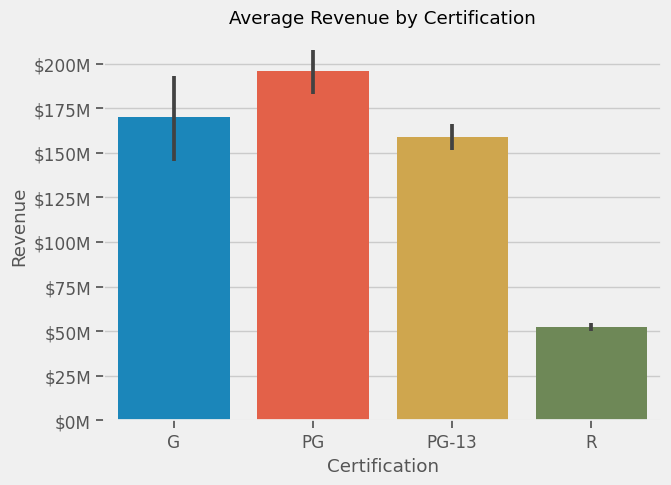

In [58]:
cert_order = ['G','PG','PG-13','R']
ax = sns.barplot(data=df_eda, x='Certification', y='Revenue', errorbar=('ci',68), order=cert_order)
ax.set_title("Average Revenue by Certification");
ax.yaxis.set_major_formatter(mill_fmt)

In [59]:
## Save certification groups revenue as dictonary
groups ={}

for cert in df_eda['Certification'].unique():
    temp = df_eda.loc[df_eda['Certification']== cert, 'Revenue']
    groups[cert] = temp

groups.keys()

dict_keys(['R', 'PG-13', 'PG', 'G'])

In [60]:
groups['G']

67      192610372
77      579700000
128     169332978
129     232225908
269      69500000
          ...    
2772       769028
3426    144327371
3430        50000
3442     10855626
3443         5000
Name: Revenue, Length: 76, dtype: int64

## Testing Assumptions

### Check for Normality

In [132]:
def check_assumptions_normality(groups_dict, alpha=.05):
    """
    The Shapiro-Wilk test tests the null hypothesis that the
    data was drawn from a normal distribution.
    """
    ## Running normal test on each group and confirming there are >20 in each group
    results = []
    for group_name, group_data in groups_dict.items():
        try:
            stat, p = stats.shapiro(group_data)
            test_name = 'Shapiro-Wilk (Normality)'
        except:
            print(f'[!] Error with {i}')
            p = np.nan
            
        ## save the p val, test statistic, and the size of the group
        results.append({'stat test':test_name, 'group':group_name, 
                        'n': len(group_data),
                         'stat':f"{stat:.5f}",
                        'p':p,#f"{p:.10f}",
                        'p (.4)':f"{p:.4f}",
                        'sig?': p<alpha})
        
    return pd.DataFrame(results).set_index(['stat test',"group"])


In [133]:
check_assumptions_normality(groups)

n     stat             p  p (.4)  sig?
stat test                group                                           
Shapiro-Wilk (Normality) R      1602  0.57287  0.000000e+00  0.0000  True
                         PG-13  1374  0.58601  0.000000e+00  0.0000  True
                         PG      528  0.68657  4.011007e-30  0.0000  True
                         G        76  0.71435  7.282728e-11  0.0000  True

- Didn't meet assumption of normality, but n is sufficiently large to disregard assumption of normality.


### No Outliers

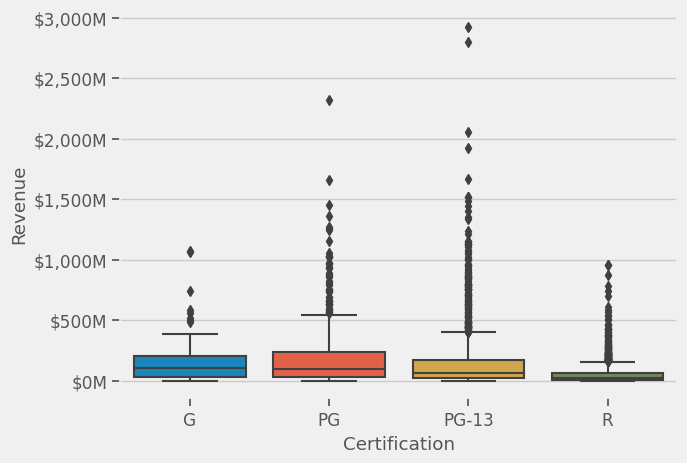

In [142]:
ax = sns.boxplot(data=df_eda,y='Revenue' , x='Certification', order=cert_order);
ax.yaxis.set_major_formatter(mill_fmt)

In [143]:
groups_cleaned = {}

for sector, data in groups.items():

    outliers = np.abs(stats.zscore(data)) > 3
    print(f"There were {outliers.sum()} ({outliers.sum()/len(outliers)*100:.2f}%) outliers in the {sector} group.")

    group_data = data.loc[~outliers]
    groups_cleaned[sector] = group_data

There were 36 (2.25%) outliers in the R group.
There were 30 (2.18%) outliers in the PG-13 group.
There were 13 (2.46%) outliers in the PG group.
There were 2 (2.63%) outliers in the G group.


> I am torn about outlier removal. It may be best to leave in outliers and perform the non-parametric test instead.

### Checking for Equal Var

In [139]:
## Check for equal variance
result = stats.levene(*groups.values())
print(result)
if result.pvalue < .05:
    print(f"- The groups do NOT have equal variance.")
else:
    print(f"- The groups DO have equal variance.")

LeveneResult(statistic=76.09451301546683, pvalue=1.0388715311270899e-47)
- The groups do NOT have equal variance.


-  Groups do not have equal variance. Therefore, use Kruskal Wallace instead of one-way ANOVA.

### Kruskal Wallis Test

In [140]:
## Running Krukal Test for Original Hypothesis
result = stats.kruskal(*groups.values())
# result = stats.f_oneway(*groups.values())
print(result)
result.pvalue<.05

KruskalResult(statistic=453.5889123145245, pvalue=5.440574448481798e-98)


True

- Our Kruskal Wallis test returned a p-value <.0001. 
- There is a significant difference in the average revenue for different movie certifications.
- A post-hoc test is needed to determine which ratings were different.

### Post-Hoc Tukey's Multiple Comparison

In [144]:
## make a list for saving the dataframes to
tukeys_dfs = []
for cert, temp in groups.items():
    temp_df = pd.DataFrame({'Revenue':temp, 'Certification':cert})
    tukeys_dfs.append(temp_df)
    
## concatenate them into 1 dataframe    
tukeys_data = pd.concat(tukeys_dfs)
tukeys_data

,Revenue,Certification
0,45600000,R
1,12300000,R
3,180906076,R
4,72258126,R
5,60740827,R
...,...,...
2772,769028,G
3426,144327371,G
3430,50000,G
3442,10855626,G


In [146]:
tukeys_data['Certification'].value_counts()

R        1602
PG-13    1374
PG        528
G          76
Name: Certification, dtype: int64

- Figure saved as Images/hypothesis_revnue_mpaa_rating.png


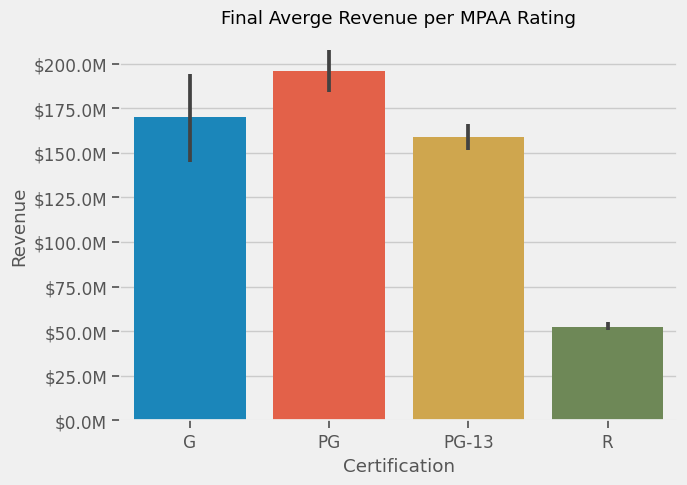

In [150]:
## Post Hoc
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# values = tukeys_data['revenue']
# labels = tukeys_data['certification']

ax = sns.barplot(data=tukeys_data, x='Certification',y='Revenue',
                 errorbar=('ci',68),
           order=cert_order)#[*cert_order,'NC-17'])
ax.yaxis.set_major_formatter(pf.get_funcformatter(kind='m'))
ax.set_title("Final Averge Revenue per MPAA Rating")
pf.savefig('Images/hypothesis_revnue_mpaa_rating.png',ax=ax,facecolor='white');

group1,group2,meandiff,p-adj,lower,upper,reject
G,PG,25904052.0687,0.7429,-39937983.2603,91746087.3977,False
G,PG-13,-10758323.7852,0.972,-73998398.4724,52481750.9019,False
G,R,-117339542.4525,0.0,-180343301.4813,-54335783.4237,True
PG,PG-13,-36662375.8539,0.0034,-64141536.5762,-9183215.1316,True
PG,R,-143243594.5212,0.0,-170174448.1898,-116312740.8525,True
PG-13,R,-106581218.6673,0.0,-126314548.5814,-86847888.7532,True


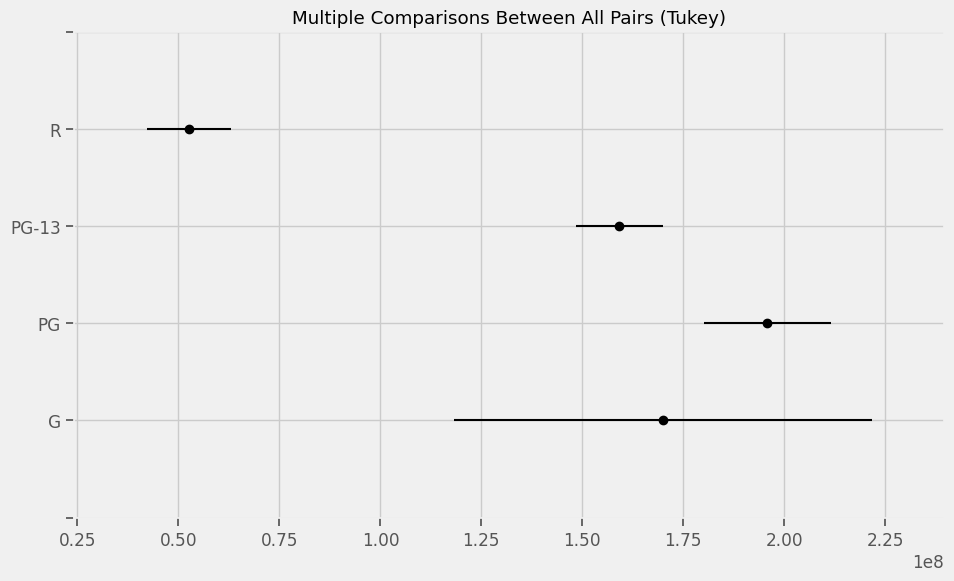

In [151]:
## perform tukey's multiple comparison test and display the summary
tukeys_results = pairwise_tukeyhsd(tukeys_data['Revenue'],tukeys_data['Certification'])
display(tukeys_results.summary())

tukeys_results.plot_simultaneous();

> According to the post-hoc Tukey's tests, G/PG/PG-13 movies make similar average revenue than all other ratings. PG movies make more money than PG-13.
> R-rated movied make significantly less revenue than every other genre.

# BOOKMARK: CONTINUE HERE

## Q2: Do movies that are over 2.5 hours long earn more revenue than movies that are 1.5 hours long (or less)?


## Hypothesis
- $H_0$ (Null Hypothesis): Movies longer tha 2.4 hours generate the same average revenue as shorter movies.
- $H_A$ (Alternative Hypothesis):  Movies longer tha 2.4 hours generate more/less average revenue than shorter movies.

### Selecting the Right Test
- We have Numerical Data
- with 2 groups
- 2-sample t-test A.K.A. Independent T-Test

### ANOVA Assumptions
- No significant outliers
- Normality
- Equal Variance